## Gaussian Process regression

### Read train and test data

In [1]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mfmodeling import SingleGP
from time import time as timer
import pickle

2025-09-22 17:50:54.944774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/maeyama/mylib/Miniforge3/envs/subB_3.12.11/lib/python3.12/site-packages/gpflow/versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
import tensorflow as tf
print(tf)

# 利用可能なデバイス一覧
print(tf.config.list_physical_devices())

print("ROCm build? ->", tf.test.is_built_with_rocm())  # True を期待
info = tf.sysconfig.get_build_info()
print("is_rocm_build:", info.get("is_rocm_build"))
print("is_cuda_build:", info.get("is_cuda_build"))

<module 'tensorflow' from '/home/maeyama/mylib/Miniforge3/envs/subB_3.12.11/lib/python3.12/site-packages/tensorflow/__init__.py'>
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
ROCm build? -> True
is_rocm_build: True
is_cuda_build: False


(521, 1) (521, 1)


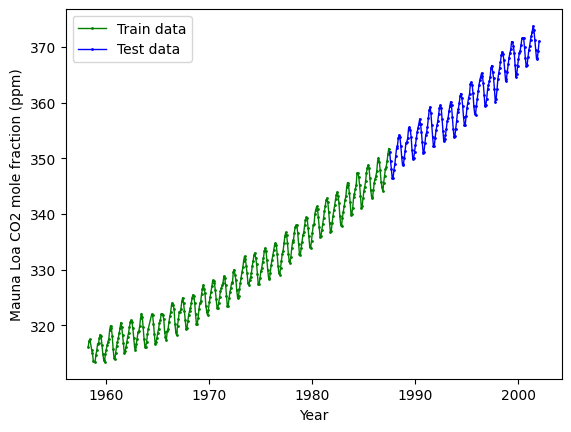

In [3]:
df = pd.read_csv("co2_data.csv")
x = df["year"].to_numpy()[:,np.newaxis]
y = df["co2"].to_numpy()[:,np.newaxis]

data_all = [x,y]
print(x.shape, y.shape)
nsplit = data_all[0].shape[0]//3*2
data_train = [x[:nsplit],y[:nsplit]]
data_test = [x[nsplit:],y[nsplit:]]

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data_train[0], data_train[1], 'g.-', label='Train data', linewidth = 1, markersize=2)
ax.plot(data_test[0], data_test[1], 'b.-', label='Test data', linewidth = 1, markersize=2)
ax.set_xlabel("Year")
ax.set_ylabel("Mauna Loa CO2 mole fraction (ppm)")
ax.legend()
plt.show()

In [4]:
def plot_singleGP_prediction(x,model_singleGP):
    mean, var = model_singleGP.predict(x)
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(data_train[0], data_train[1], 'g.-', label='Train data', linewidth = 1, markersize=2)
    ax.plot(data_test[0], data_test[1], 'b.-', label='Test data', linewidth = 1, markersize=2)
    ax.plot(x[:,0], mean[:,0], 'r', label = 'SingleGP prediction', linewidth = 1)
    ax.fill_between(x[:,0], (mean[:,0]-2.0*np.sqrt(var[:,0])).ravel(), (mean[:,0]+2.0*np.sqrt(var[:,0])).ravel(), alpha=0.1, color='red')
    ax.set_xlabel("Year")
    ax.set_ylabel("Mauna Loa CO2 mole fraction (ppm)")
    ax.set_ylim(310,390)
    ax.legend()
    plt.show()

#### (i) RBF kernel (Optimized lengthscale)

optimize_restarts= 5 , max_iters= 400


2025-09-22 17:51:07.144961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 129516 MB memory:  -> device: 0, name: AMD Instinct MI300A, pci bus id: 0002:02:00.0
2025-09-22 17:51:24.096219: I tensorflow/core/util/rocm_solvers.cc:125] Creating GpuSolver handles for stream 0x55b56c7e0bb0
2025-09-22 17:51:28.194830: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:28.201468: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:28.203432: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output wit

Optimization restart 1/5,  f =  748.4821322278137


2025-09-22 17:51:28.938385: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:28.940472: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:28.942547: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:28.944506: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:28.946516: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for ba

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,144129.80338
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[107.25215]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02734


Optimization restart 2/5,  f =  748.4828631822106


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,138022.25426
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[106.31981]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02709


Optimization restart 3/5,  f =  748.4821319759026


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,144096.22887
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[107.2438]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02735


Optimization restart 4/5,  f =  748.4821321160263


2025-09-22 17:51:30.127163: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:30.129313: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:30.131364: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:30.133523: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-22 17:51:30.135549: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for ba

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,144159.88931
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[107.25535]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02735


Optimization restart 5/5,  f =  749.981854297162


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,30890.36255
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[76.78411]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02631


Elapsed time [sec]= 23.522074937820435


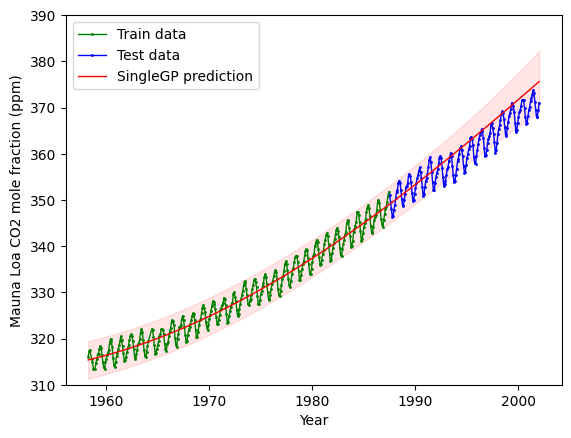

In [5]:
t1=timer()
# Create Single GP instance with training data set
model_singleGP = SingleGP(data=data_train,
                         kernel="RBF",
                         normalize=False)

# Optimize hyper parameters
model_singleGP.optimize(optimize_restarts=5, verbose=True)
t2=timer();print("Elapsed time [sec]=",t2-t1)

# Save the optimized model as a pickel
with open("model_singleGP_RBF.pkl","wb") as f:
    pickle.dump(model_singleGP,f)

# Check the regression result
plot_singleGP_prediction(x, model_singleGP)

### (ii) RBF kernel (Fixed lengthscale=0.5)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value        │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 144096.22887 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [107.2438]   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 4.02735      │
╘═════════════════════════╧═══════════╧═════════════════

 This problem is unconstrained.


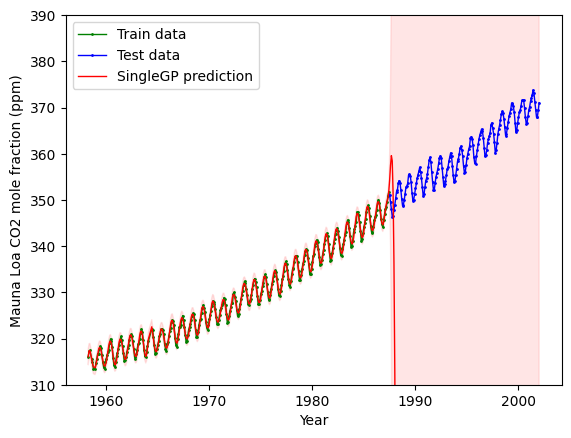

In [6]:
import gpflow
gpflow.utilities.print_summary(model_singleGP.model)

# Fix lengthscale=0.5 and train the other hyperparameters
model_singleGP.model.kernel.lengthscales.assign([0.5])
gpflow.utilities.set_trainable(model_singleGP.model.kernel.lengthscales, False)
opt = gpflow.optimizers.Scipy()
opt.minimize(model_singleGP.model.training_loss,
             model_singleGP.model.trainable_variables,
             method="L-BFGS-B", options={"maxiter": 400, "disp": True})
gpflow.utilities.print_summary(model_singleGP.model)

# Save the optimized model as a pickel
with open("model_singleGP_RBF_length0.5.pkl","wb") as f:
    pickle.dump(model_singleGP,f)

# Check the regression result
plot_singleGP_prediction(x, model_singleGP)

### (iii) Spectral Mixture Kernel

optimize_restarts= 10 , max_iters= 400
Optimization restart 1/10,  f =  747.221899839303


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[6.31147306e+003, 0.00000000e+000, 3.13483350e+002..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[5.63697779e-153, 3.81460500e+001, 2.10482121e-113..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[0., 0., 0...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02281


Optimization restart 2/10,  f =  747.2535902534411


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[0.00000000e+000, 2.53793170e+002, 0.00000000e+000..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[5.52052597e-120, 7.04245370e-124, 2.32661091e-098..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[0., 0., 0...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02298


Optimization restart 3/10,  f =  472.42380788535024


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[6.88123003e-196, 0.00000000e+000, 6.47685416e+003..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[1.51185658e-313, 0.00000000e+000, 0.00000000e+000..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[0.00000000e+00, 7.21147653e+04, 0.00000000e+00..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


Optimization restart 4/10,  f =  762.656385801736


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[4.80549923e-122, 9.24584600e+001, 2.92276784e+003..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[9.66687959e-019, 0.00000000e+000, 5.06718901e-049..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[0., 17652.55508, 0...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.04737


Optimization restart 5/10,  f =  344.44827250163587


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[0.00000000e+000, 0.00000000e+000, 1.78705000e+000..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[3.07361578e-196, 0.00000000e+000, 2.51058085e+003..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[1.82564082e+03, 5.19823554e+04, 4.03481414e-02..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


Optimization restart 6/10,  f =  200.54335734293545


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[1.19393498e-026, 2.00108000e+000, 2.15550518e-024..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[4.90356995e-188, 2.29640472e-307, 3.56785255e-235..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[1.60780981e-231, 2.54056901e-001, 6.94427472e-267..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.09818294785072822


Optimization restart 7/10,  f =  230.68642539206274


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[2.26480976e-307, 0.00000000e+000, 0.00000000e+000..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[1.25840854e-057, 3.72628540e-103, 0.00000000e+000..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[8.22952453e-107, 6.37851276e-119, 2.14547523e+003..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.15078850543457142


Optimization restart 8/10,  f =  747.3307455495872


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[1.02287752e+003, 0.00000000e+000, 0.00000000e+000..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[7.85176502e-19, 3.14372000e+00, 4.93468187e-06..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[0., 0., 16820.78574..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02336


Optimization restart 9/10,  f =  157.0788339648255


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[1.44483367e-062, 3.17349837e-292, 2.59608537e-036..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[6.61360800e+001, 5.95339330e-005, 5.62590045e-062..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[9.08642677e-51, 2.59537090e+02, 4.34097632e-74..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


Optimization restart 10/10,  f =  747.3061431973231


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.mean_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[2.08866103e+003, 1.62902710e+002, 4.41152090e+002..."
GPR.kernel.variance_list,Parameter,Softplus,,True,"(1, 20)",float64,"[[1.59329364e-088, 4.46405149e-015, 2.93125088e-051..."
GPR.kernel.weight_list,Parameter,Softplus,,True,"(20,)",float64,"[0., 0., 0...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.02184


Elapsed time [sec]= 17.40794610977173


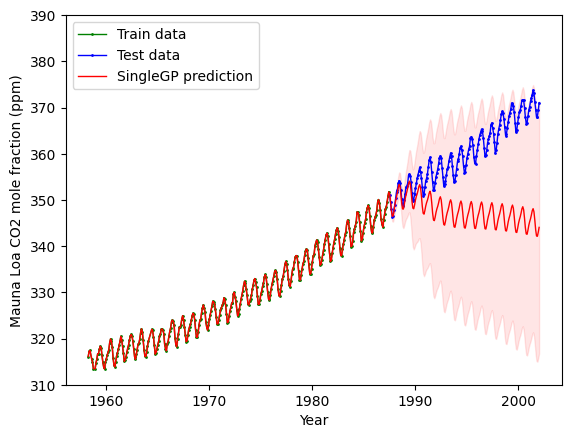

In [9]:
t1=timer()
# Create Single GP instance with training data set
model_singleGP = SingleGP(
    data = data_train,
    kernel = "SpectralMixture",
    kernel_args = {"n_components": 20}  # Spectral Mixture Kernel with 20 components.
    )

# Optimize hyper parameters
model_singleGP.optimize(optimize_restarts=10, verbose=True)
t2=timer();print("Elapsed time [sec]=",t2-t1)

# Save the optimized model as a pickel
with open("model_singleGP_SMK.pkl","wb") as f:
    pickle.dump(model_singleGP,f)

# Check the regression result
plot_singleGP_prediction(x, model_singleGP)

### (iv) Neural Kernel Network

I0000 00:00:1758531116.342403  322678 service.cc:146] XLA service 0x14cc1149f510 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758531116.345804  322678 service.cc:154]   StreamExecutor device (0): AMD Instinct MI300A, AMDGPU ISA version: gfx942:sramecc+:xnack-
2025-09-22 17:51:56.527194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758531118.166106  322678 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Elapsed time [sec]= 186.3255636692047


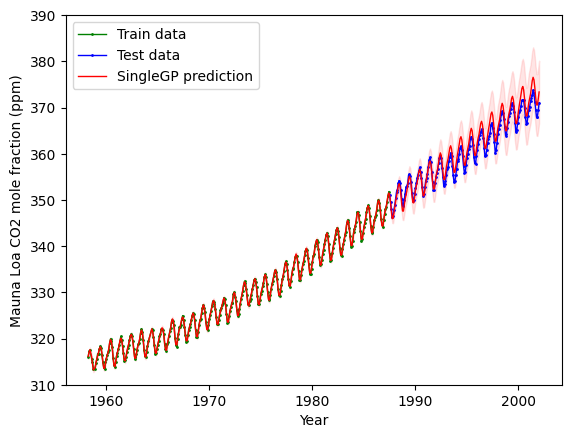

In [8]:
t1=timer()

import gpflow
# Define primitive kernels and neural network
primitive_kernels = [
    {'name': 'Linear'},
    # periodic kernel requires base kernel setting.
    {'name': 'Periodic', 'params': {'base_kernel': gpflow.kernels.SquaredExponential()}},
    {'name': 'ExpQuad'},
    {'name': 'RatQuad'},
    {'name': 'Linear'},
    {'name': 'RatQuad'},
    {'name': 'ExpQuad'},
    # periodic kernel requires base kernel setting.
    {'name': 'Periodic', 'params': {'base_kernel': gpflow.kernels.SquaredExponential()}}]
neural_network = [
        {'name': 'Linear',  'params': {'input_dim': 8, 'output_dim': 8}},
        {'name': 'Product', 'params': {'input_dim': 8, 'step': 2}},
        {'name': 'Linear',  'params': {'input_dim': 4, 'output_dim': 4}},
        {'name': 'Product', 'params': {'input_dim': 4, 'step': 2}},
        {'name': 'Linear',  'params': {'input_dim': 2, 'output_dim': 1}}]


# Create Single GP instance with training data set
model_singleGP = SingleGP(
    data = data_train,
    kernel = "NeuralKernelNetwork",
    # Pass the primitive kernels and neural network via "kernel_args" key
    kernel_args = {"neural_network": neural_network,
                   "primitive_kernels": primitive_kernels},
    normalize=True  # Normalize data for stability
    )

# Optimize hyperparameters with Adam
model_singleGP.optimize(
    verbose=False,
    optimizer_name="Adam",
    max_iters=2000,
    optimizer_parameters={"learning_rate": 0.01},
    optimize_restarts=5,
    # Use built-in random initialization of the NeuralKernelNetwork class
    use_built_in_initialization=True,
    plot_history=False)

# Save the optimized model as a pickel
t2=timer();print("Elapsed time [sec]=",t2-t1)

with open("model_singleGP_NKN.pkl","wb") as f:
    pickle.dump(model_singleGP,f)

# Check the regression result
plot_singleGP_prediction(x, model_singleGP)